In [28]:
#For final run only, we'll ignore warnings to supress deprecation warnings, etc.
import warnings
warnings.filterwarnings('ignore')
#warnings.filterwarnings('default')

# Title and Introduction
#### Madalyn Beban and Karl Hetzke
---

*In this first section, introduce the assignment and the selection of our two series.  What are we trying to accomplish (forecasting, duh) but also what did we find along the way (anything interesting to say, conclusions about ethnic differences in labor-force participation, etc.).*

In our **Plots and Patterns** section, we begin with a presentation of plots, correlograms, and diagnostic tests on the series as a whole (not broken into training or testing sets).  From plots we observe strong seasonality that decreases in magnitude over time, which lead us evaluate models with monthly dummy variables and a seasonal AR(12) term.  From Augmented Dickey-Fuller tests we observe that our two series likely contain unit roots in levels, but not in first differences; from these ADF tests we decided to compare models of the series in levels with a deterministic trend, and models of the series in first-differences.

We move on to present the results of three models evaluated on the two series of interest.  For each model, we split the series into a training series and testing series using the first 80% of observations as training data and the remainder as a testing set.  For each model, we perform a regression on training data and calculate RMSE to evalue forecast performance using the testing data.  In our tables for each model, we present a full summary of regression results and fit-statistics, the value of RMSE for forecast series, a plot of true values, fitted values and forecast values, and a correlogram of the residuals from the training data.

**Model 1** is an OLS regression on a trend term (t1) and trend-squared (t2), plus monthly dummy variables. From evaluating correlograms of residuals on these models we concluded that both series contain an AR(1) process after control for trend, and that monthly dummy variables are not sufficient to capture all seasonal autocorrelation, which led us to Model 2.  

**Model 2** is a Seasonal AR(1) model with quadratic trend and a single 12-period lag. This sufficiently removes most auto-correlation in residuals, but leaves some seasonal patterns uncaptured. On Black_LPR, forecast performance is weak as the deterministic trend appears to follow the series poorly.  The relatively poor performance of these models for fitting the stochastic trend of Black_LPR lead us to Model 3.

**Model 3** evaluates the series in first-differences using Seasonal-ARIMA without trend and with ARIMA order(1,1,1) and seasonal order (1,0). 

After presenting each model, we provide a discussion of why Model 3 is the most appropriate model for forecasting these two series into the future, and using Model 3 we present a forecast of the two series up to 2025. 

In [2]:
# Import Necessary Packages 
import pandas as pd
import numpy as np
import statsmodels.tsa.stattools as stattools
import statsmodels.graphics.tsaplots as statplots
from statsmodels.tsa.arima_model import ARIMA
import datetime # new
from dateutil.relativedelta import relativedelta # new
import math
import statsmodels.api as sm

# Set some preferences for plotting
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [6.472, 4] #golden ratio...
plt.rcParams['figure.dpi'] = 72*1.75
from textwrap import wrap

#Load Data from FRED database (St. Lousis Federal Reserve):
url = r'https://fred.stlouisfed.org/graph/fredgraph.csv?bgcolor=%23e1e9f0&chart_type=line&drp=0&fo=open%20sans&graph_bgcolor=%23ffffff&height=450&mode=fred&recession_bars=on&txtcolor=%23444444&ts=12&tts=12&width=1168&nt=0&thu=0&trc=0&show_legend=yes&show_axis_titles=yes&show_tooltip=yes&id=LNU01300003,LNU01300006&scale=left,left&cosd=1972-01-01,1972-01-01&coed=2021-03-01,2021-03-01&line_color=%234572a7,%23aa4643&link_values=false,false&line_style=solid,solid&mark_type=none,none&mw=3,3&lw=2,2&ost=-99999,-99999&oet=99999,99999&mma=0,0&fml=a,a&fq=Monthly,Monthly&fam=avg,avg&fgst=lin,lin&fgsnd=2020-02-01,2020-02-01&line_index=1,2&transformation=lin,lin&vintage_date=2021-04-11,2021-04-11&revision_date=2021-04-11,2021-04-11&nd=1954-01-01,1972-01-01'
df = pd.read_csv(url, parse_dates = ['DATE'])
df = df.set_index('DATE')
df = df.rename(columns = {'LNU01300003' : 'White_LPR', 'LNU01300006': 'Black_LPR'})

# Add a constant, some trend variables, and monthly dummies
df['cons'] = 1
df['t1'] = range(1,len(df)+1)
df['t2'] = df['t1']**2 
dummies = pd.get_dummies(df.index.month, prefix='month', drop_first=False).set_index(df.index)
df = df.join(dummies)

# Add some dummy variables that indicate macro-economic events or policy hypotheses
#set up a dictionary that we can easily add lists of dates to (listed as pairs of start/end dates where dummy_var=1)
dummy_dates = {
    'gop_house' : [['1995-01-01','2006-12-01'],['2011-01-01','2018-12-01']],
    'gop_senate' : [['1981-01-01','1986-12-01'],['1995-01-01','2000-12-01'],['2003-01-01','2006-12-01'],['2015-01-01','2020-12-01']],
    'gop_potus' : [['1972-01-01','1976-12-01'],['1981-01-01','1992-12-01'],['2001-01-01','2008-12-01'],['2017-01-01','2020-12-01']],
    'covid_19' : [['2020-04-01','2021-03-01']]
    }

for var in dummy_dates:
    df[var] = 0
    for rng in dummy_dates[var]:
        flt = (df.index >= rng[0]) & (df.index <= rng[1])
        df[var].loc[flt] = 1
        
#Split into training and testing data-sets using first 80% of observations as data
df_train = df[0:math.ceil(len(df)*0.8)]
df_test = df[math.ceil(len(df)*0.8):]

#Print out some basic features of the data for easy reference
print('Total Dataset:', len(df))
print('Training Size:', len(df_train))
print('Testing Size:', len(df_test))
print(df.columns.tolist())
df.head()


Total Dataset: 591
Training Size: 473
Testing Size: 118
['White_LPR', 'Black_LPR', 'cons', 't1', 't2', 'month_1', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12', 'gop_house', 'gop_senate', 'gop_potus', 'covid_19']


,White_LPR,Black_LPR,cons,t1,t2,month_1,month_2,month_3,month_4,month_5,...,month_7,month_8,month_9,month_10,month_11,month_12,gop_house,gop_senate,gop_potus,covid_19
DATE,,,,,,,,,,,,,,,,,,,,,
1972-01-01,59.7,58.1,1,1,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1972-02-01,59.6,58.7,1,2,4,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1972-03-01,60.0,59.3,1,3,9,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
1972-04-01,59.9,58.8,1,4,16,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
1972-05-01,59.9,59.2,1,5,25,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0


In [3]:
#Helper Functions
def correlogram(srs, nlags = 30, plot_title='Correlogram of my series', display_plots = True, display_table = True, save_df = False):
    acf, confint, q_stat, p_val = stattools.acf(srs, nlags=nlags,alpha=0.05, qstat=True, fft = False)
    pacf,pconfint = stattools.pacf(srs, alpha=0.05, nlags=nlags)
    cf_df = pd.DataFrame([acf,pacf,q_stat,p_val],index = ['ACF','PACF','Q-Stat','P-value']).transpose()
    cf_df = cf_df[1:]
    if display_table:
        print('======================================================')
        print('======== '+ plot_title + ' =========')
        print('======================================================')
        print(cf_df)
    if display_plots:
        ax = cf_df[['ACF','PACF']].plot(kind="bar", title=plot_title ,ylabel = "Correlation",xlabel="Number of Lags",ylim=(-1,1))
        ax.fill_between(range(nlags), confint[1:, 0] - acf[1:], confint[1:, 1] - acf[1:], alpha=0.25, color = 'grey')
        ax.fill_between(range(nlags), pconfint[1:, 0] - pacf[1:], pconfint[1:, 1] - pacf[1:], alpha=0.25, color = 'pink')
    if save_df:
        return cf_df
    else:
        return

def eval_forecast(result,training_df, testing_df, future_exog = None, display_plot = True, summarize=True, ols = False, display_correlo=True, model_title = 'Model'): 
    
    #Extract Forecast values from result class, depending on we're using SARIMAX or OLS, and if we have future-exogenous
    training_df['Fitted'] = result.fittedvalues
    if future_exog is not None:
        if ols:
            forecast_vals = result.predict(future_exog)
        else:
            forecast_vals = result.forecast(exog=future_exog,steps=len(testing_df))
    else: 
        forecast_vals = result.forecast(len(testing_df))
    testing_df['Forecast'] = forecast_vals
    full_df = training_df.append(testing_df)
    
    #Display options...
    if display_plot:
        ax = full_df[1:].plot(title = model_title + ' Performance', xlabel = 'Year')
        ax.axvline("2011-05-15", color="red", linestyle="dashed", lw=0.5)
    if summarize:
        testing_df['Sq_Error'] = (testing_df[testing_df.columns[0]] - testing_df['Forecast'])**2
        MSE = testing_df[['Sq_Error']].mean()
        RMSE = MSE[0]**0.5
        print('======================================================')
        print('RMSE of Forecast is', RMSE)
        print('======================================================')
    if display_correlo:
        correlogram(result.resid[1:], nlags = 30, plot_title=model_title + ' Residual Correlogram', display_plots = True, display_table = False, save_df = False)
    return

from statsmodels.tsa.stattools import adfuller
def aug_dickeyfuller(df):
    res = adfuller(df[df.columns[0]])
    new_res = [df.columns[0],res[0], res[1]]
    return new_res


### Plots and Patterns
---
After visual inspection of the two series in levels (see Figure 1), three things are made very clear: 
1. the series are not covariance stationary, and likely has a unit root
2. there is strong seasonality in both series, and that seasonality changes over time 
3. any long-run trends are complicated, we can try to approximate them deterministically or treat them as random-walk processes

**On the presence of a unit root** the two correlograms of the two series (Figures 2 and 3) are typical of series that contain a unit root with ACFs that damp very slowly.  From augmented Dickey Fuller (ADF) tests on both series (see Table 1) we fail to reject the null hypothesis of a unit root, so we conclude that these two series likely contain a unit root and are not covariance stationary. After taking first differences of both series and conducting another ADF test, we reject the null hypothesis of a unit root for Black LPR in first differences, but fail to reject the null for White LPR in first differences.  This suggests that Black_LPR has an order of integration I(1), but White_LPR may have a higher order of integration.  After taking differences in differences and conducting a third round of ADF tests, we confidently reject the null of a unit root for both series.  It seems odd that these two series would have different orders of integration given that these series represent the same macro-economic phenomonon just measured among different populations, but the ADF tests suggest this difference.

**Regarding seasonality**, the correlograms also show evidence of seasonality with increases ACF at 12 and 24 lags, and increases in PACF at 13 and 25 lags.  From Figure 1 we can see that the magnitue of seasonal fluctuation is not constant and appears to be decreasing over time.  Figures 1-3 also reveal that the magnitude of seasonal fluctuation is greater in the black population than white population, which may be an indicator that a larger share of the black population engages in work with seasonal variability.

The clear damping over time of magnitude of seasonal fluctuation suggests that we cannot adequately model seasonality in this series with just monthly dummy variables, but must either interact those seasonal dummy variables with a trend variable, or use a seasonal ARMA method where we include a 12 or 24 period lag-term in our model.


**Regarding trend**, it is likely this trend is best understood as a random-walk process, but if we were forecasting with a relatively short time-horizon it might make sense to treat each series with a deterministic, quadratic trend.

The vertical red line in Figure 1 represents where our training series ends and testing series begins.  The series follows a persistent downward trend in the last months of the training series, but this trend reverses shortly after after the start of the training set until 2020 where both series display a sharp drop, obviously related to the COVID-19 pandemic and associated economic shutdowns. Any deterministic trend model is unlikely to forecast the late upswing beginning around 2014, and no model based purely on these series could predict the drop due to COVID-19.  

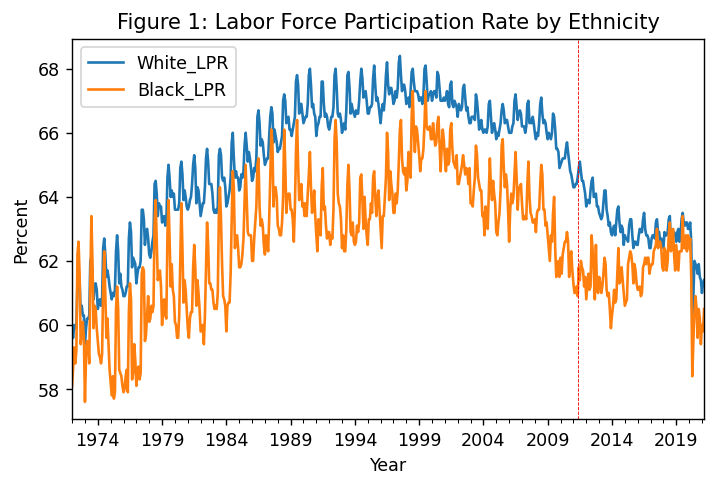

In [4]:
# Basic two-series plot in levels, with vertical line indicating train/test split
ax = df[['White_LPR','Black_LPR']].plot(title = 'Figure 1: Labor Force Participation Rate by Ethnicity',
                                        ylabel = 'Percent', xlabel = 'Year')
ax = ax.axvline("2011-05-15", color="red", linestyle="dashed", lw=0.5)

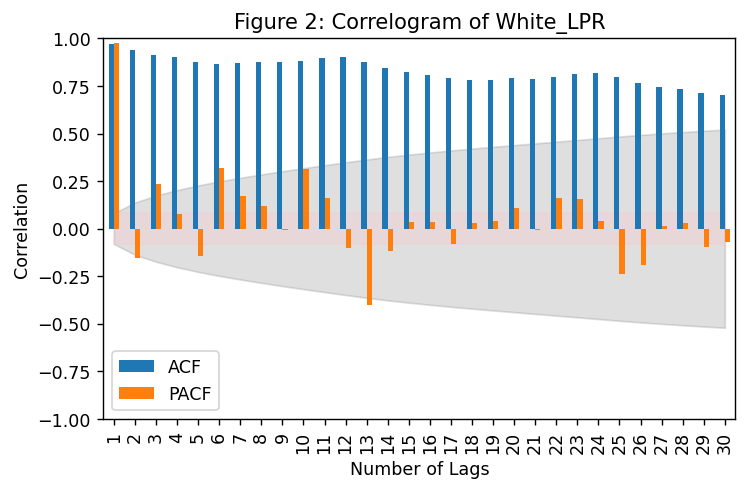

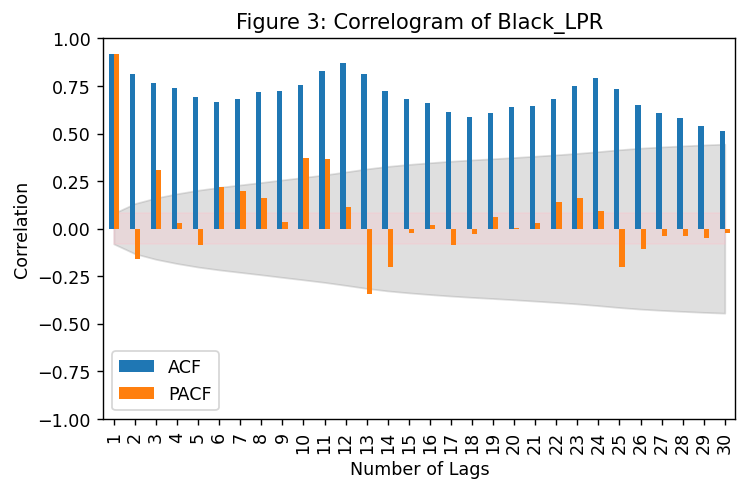

In [5]:
#Correlograms of two series
correlogram(df['White_LPR'],plot_title = 'Figure 2: Correlogram of White_LPR', display_table = False)
correlogram(df['Black_LPR'],plot_title = 'Figure 3: Correlogram of Black_LPR', display_table = False)

In [6]:
#Take the series in first-differences, and then differences of first-differences
df['White_LPR_D1'] = df['White_LPR'].diff()
df['Black_LPR_D1'] = df['Black_LPR'].diff()

df['White_LPR_D2'] = df['White_LPR_D1'].diff()
df['Black_LPR_D2'] = df['Black_LPR_D1'].diff()


#Conduct Dickey-Fuller Tests of the two Series and format as a table
ADF_Tests = pd.DataFrame(columns = ['Series','Test-Stat','PValue'])
for srs in ['White_LPR','Black_LPR','White_LPR_D1','Black_LPR_D1','White_LPR_D2','Black_LPR_D2']:
    temp = aug_dickeyfuller(df[[srs]].dropna()) 
    tdf = pd.DataFrame(temp, index = ['Series','Test-Stat','PValue']).transpose()
    ADF_Tests = ADF_Tests.append(tdf)
print('Table 1: Augmented Dickey-Fuller Test Results for Series in Levels, First Differences (D1), and Differences in Differences (D2)')
ADF_Tests = ADF_Tests.set_index('Series')
ADF_Tests

Table 1: Augmented Dickey-Fuller Test Results for Series in Levels, First Differences (D1), and Differences in Differences (D2)


,Test-Stat,PValue
Series,,
White_LPR,-0.791726,0.82154
Black_LPR,-1.40303,0.580821
White_LPR_D1,-2.42922,0.133657
Black_LPR_D1,-6.97604,8.42405e-10
White_LPR_D2,-9.0902,3.84266e-15
Black_LPR_D2,-11.0052,6.53045e-20


### Model 1: Deterministic (Quadratic) Trend with Monthly Dummies

For our first model, we regressed each series on a trend variable, trend-squared, and monthly dummy variables. Estimation results for Models 1A (White_LPR) and 1B (Black_LPR) are presented below.

Model 1 performs surprisingly well given that we know before estimating the series does not actually follow a perfect quadratic trend with constant seasonal fluctuation. All independent variables are statistically significant, though this is hardly surprising given the series is obviously trending over time and obviously has seasonality.  The relatively strong forecast perhaps driven by coincidence of the COVID-crisis putting the series back on a downward trend after the testing-data was clearly trending upward away from the downward arch of our estimated trend.

From evaluating correlograms of residuals on both series, we can observe remaining seasonal patterns still uncaptured, which can be attributed to changing seasonality that monthly dummy variables are innappropriate for.  The monthly dummy variables, however, did remove much seasonal autocorrelation and from the correlograms on residuals we can now see much more clearly that these two series appear to follow an AR(1) process.  For model 2, we attempt to capture this AR(1) process and capture more seasonality by estimating a seaonal AR(1) model with quadratic trend.

Finally, it is interesting to note how much better this simple model performs for White_LPR than Black_LPR. This appears to be driven by a higher degree of volatility in Black_LPR which is likely relective of a higher level of job-insecurity in the black population compared to the white population.

     Model 1A: White_LPR regressed on Trend, Trend^2 and Seasonal Dummies     
Dep. Variable:              White_LPR   R-squared:                       0.972
Model:                            OLS   Adj. R-squared:                  0.972
Method:                 Least Squares   F-statistic:                     1247.
Date:                Sat, 01 May 2021   Prob (F-statistic):               0.00
Time:                        14:04:28   Log-Likelihood:                -164.16
No. Observations:                 473   AIC:                             356.3
Df Residuals:                     459   BIC:                             414.5
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
t1             0.0466      0.000     99.207      0.0

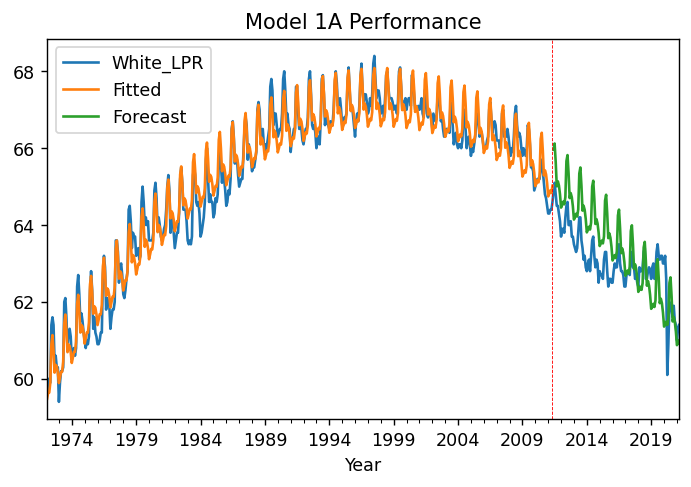

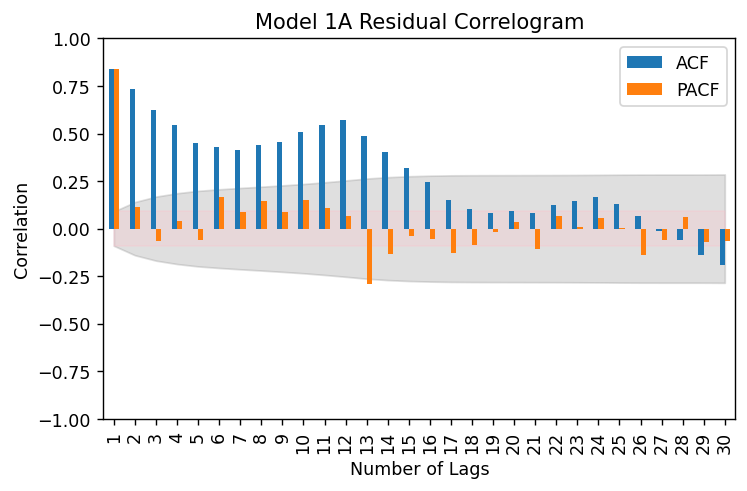

In [7]:
#Quadratic Trend with Seasonal Dummies, White
model = sm.OLS(df_train['White_LPR'], df_train[['t1','t2','month_1', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12']])
result = model.fit()
print(result.summary(title = 'Model 1A: White_LPR regressed on Trend, Trend^2 and Seasonal Dummies'))
eval_forecast(result, df_train[['White_LPR']], df_test[['White_LPR']], model_title = 'Model 1A', ols = True, future_exog = df_test[['t1','t2','month_1', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12']])

     Model 1B: White_LPR regressed on Trend, Trend^2 and Seasonal Dummies     
Dep. Variable:              Black_LPR   R-squared:                       0.815
Model:                            OLS   Adj. R-squared:                  0.810
Method:                 Least Squares   F-statistic:                     155.7
Date:                Sat, 01 May 2021   Prob (F-statistic):          6.64e-159
Time:                        14:04:30   Log-Likelihood:                -624.99
No. Observations:                 473   AIC:                             1278.
Df Residuals:                     459   BIC:                             1336.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
t1             0.0388      0.001     31.208      0.0

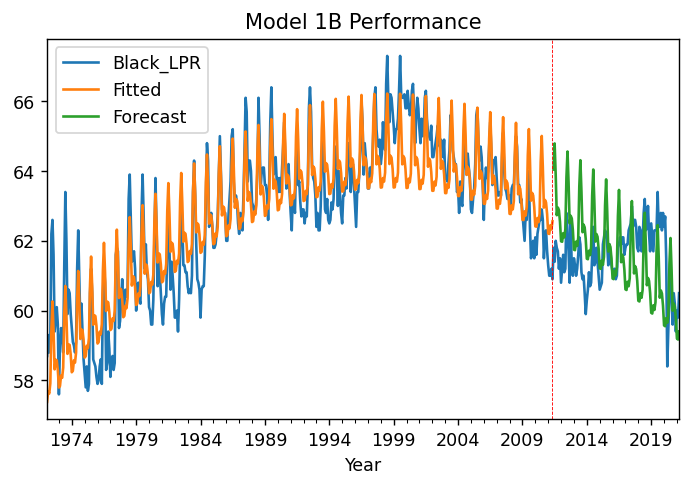

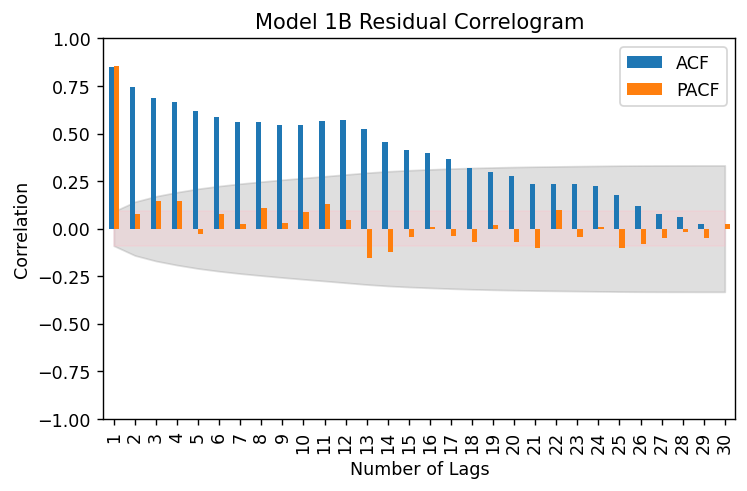

In [8]:
#Quadratic Trend with Seasonal Dummies, Black
model = sm.OLS(df_train['Black_LPR'], df_train[['t1','t2','month_1', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12']])
result = model.fit()
print(result.summary(title = 'Model 1B: White_LPR regressed on Trend, Trend^2 and Seasonal Dummies'))
eval_forecast(result, df_train[['Black_LPR']], df_test[['Black_LPR']], model_title = 'Model 1B', ols = True, future_exog = df_test[['t1','t2','month_1', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12']])

### Model 2: AR(1) with Seasonal Lag(AR(12)) and Quadratic Trend

For our second model, we estimated an AR(1) process with a seasonal AR(12) lag term and a constant, trend and trend-squared as exogenous variables to account for trend. Estimation results for models 2A and 2B are reported below.

From correlograms of residuals, we observe that our conclusions from Model 1 appear correct that this series contains an AR(1) process with trend and seasonality.  The only auto-correlation patterns that remain in residuals appear to be yet uncaptured seasonality. **MADALYN, maybe include monthly dummies in these code cells and see if that improves this**

From Model 1, the forecast performance measured by RMSE improves for White_LPR, but is much worse for Black_LPR.  As with model 1, this appears to be due to trend-volatility where the deterministic trend works well enough for White_LPR (given the down-turn due to COVID, otherwise this forecast would still perform poorly).  The residual correlograms suggest there aren't much more auto-regressive patterns to exploit, and even improving our modeling of seasonality wont help us address the real issue we have, which is a volatile trend.  

For Model 3, we attempt to address the trend issue by evaluating the series in first-differences.

Model 2A: AR(1) with Seasonal AR(12) and quadratic trend
                                     SARIMAX Results                                      
Dep. Variable:                          White_LPR   No. Observations:                  473
Model:             SARIMAX(1, 0, 0)x(1, 0, 0, 12)   Log Likelihood                 -66.172
Date:                            Sat, 01 May 2021   AIC                            144.345
Time:                                    15:02:51   BIC                            169.299
Sample:                                01-01-1972   HQIC                           154.160
                                     - 05-01-2011                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
cons          59.8304      1.779     33.638      0.000   

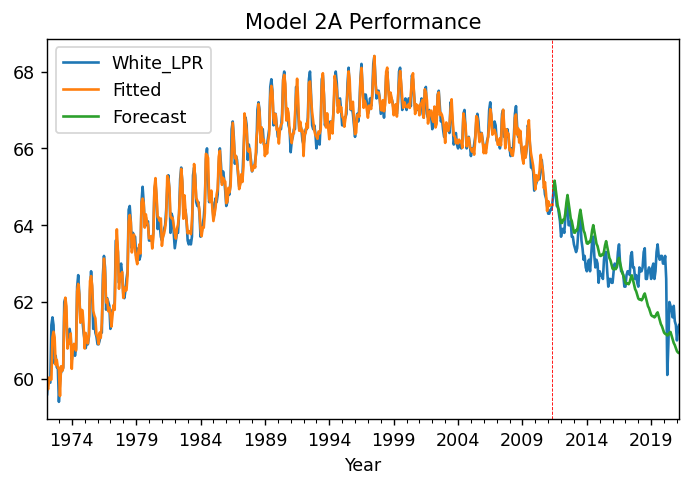

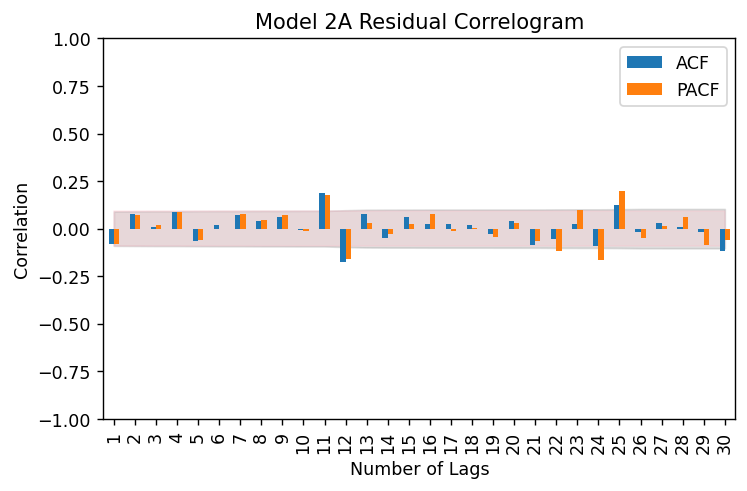

In [29]:
#The SARIMAX package "trend" argument gives odd results, so putting in trend/constant as exogenous variables
model = sm.tsa.SARIMAX(df_train[['White_LPR']],order = (1,0,0), seasonal_order = (1,0,0,12),trend=[0],exog = df_train[['cons','t1','t2']])
result = model.fit()
print('Model 2A: AR(1) with Seasonal AR(12) and quadratic trend')
print(result.summary())
eval_forecast(result, df_train[['White_LPR']], df_test[['White_LPR']], future_exog = df_test[['cons','t1','t2']], model_title = 'Model 2A')

Model 2B: AR(1) with Seasonal AR(12) and quadratic trend
                                     SARIMAX Results                                      
Dep. Variable:                          Black_LPR   No. Observations:                  473
Model:             SARIMAX(1, 0, 0)x(1, 0, 0, 12)   Log Likelihood                -427.740
Date:                            Sat, 01 May 2021   AIC                            867.480
Time:                                    15:02:57   BIC                            892.435
Sample:                                01-01-1972   HQIC                           877.295
                                     - 05-01-2011                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
cons          58.1210      2.409     24.125      0.000   

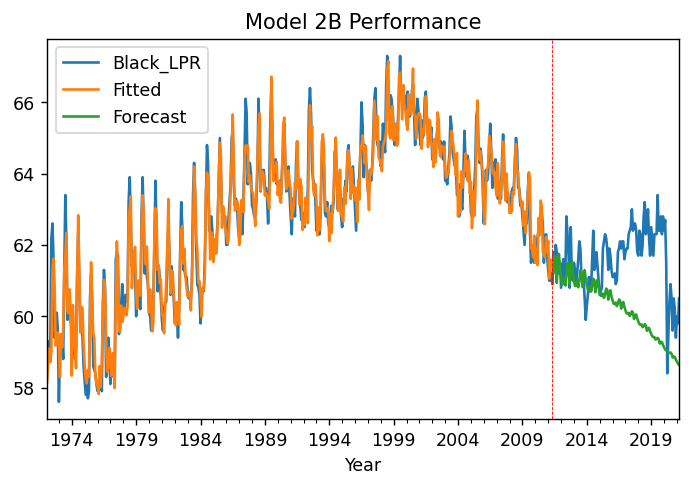

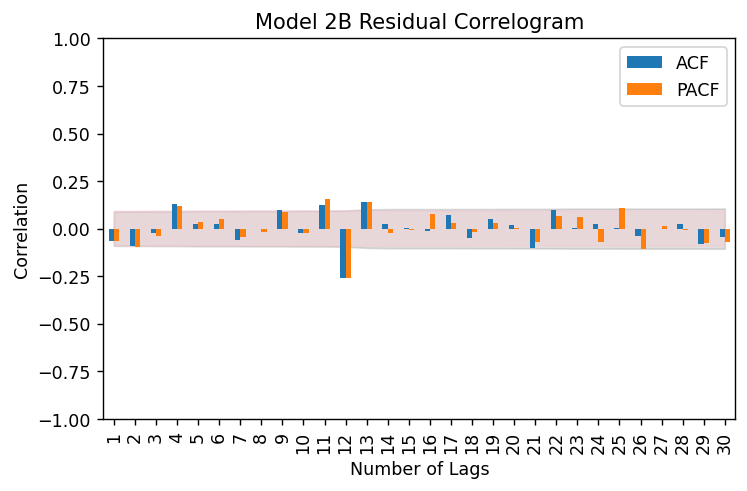

In [30]:
#Same as above, for black
model = sm.tsa.SARIMAX(df_train[['Black_LPR']],order = (1,0,0), seasonal_order = (1,0,0,12),trend=[0],exog = df_train[['cons','t1','t2']])
result = model.fit()
print('Model 2B: AR(1) with Seasonal AR(12) and quadratic trend')
print(result.summary())
eval_forecast(result, df_train[['Black_LPR']], df_test[['Black_LPR']], future_exog = df_test[['cons','t1','t2']], model_title = 'Model 2B')

### Modeling in First-Differences using ARIMA(p,1,q) with Seasonal(AR(12)); no trend

One thing I observe here is that the conclusion that this is an AR(1) process that we derived when modeling in levels does not hold when we model in first-differences.  ARIMA(1,1,1) performs much better for black than ARIMA(1,1,0). Since we are switching to first differences, we should probably do some examination of plots and correlograms; and seasonally adjusted correlograms before displaying a model of some ARIMA process.


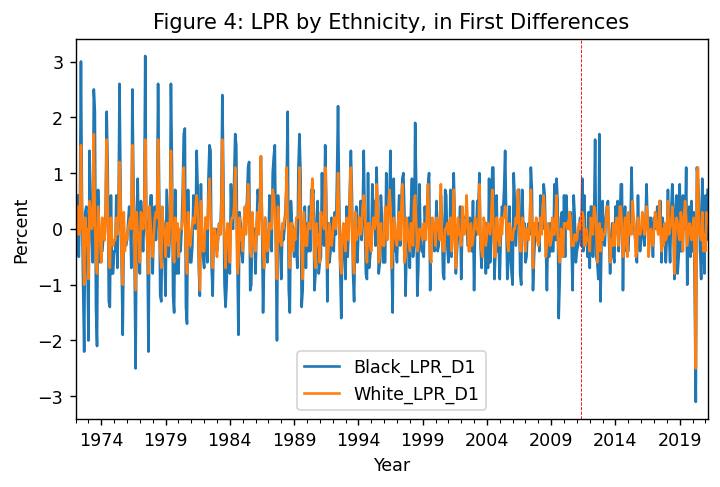

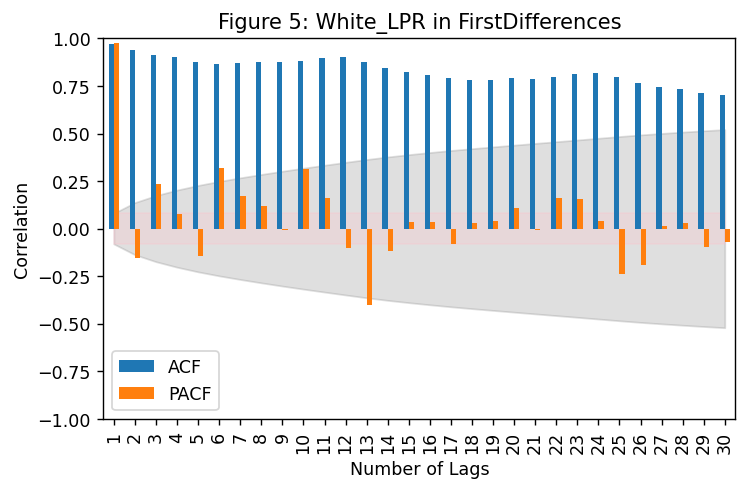

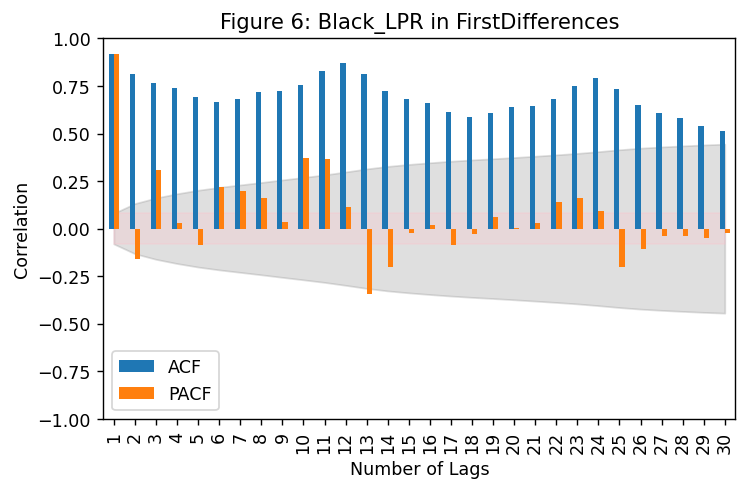

In [11]:
#Plot in First Differences, and Correlograms
ax = df[['Black_LPR_D1','White_LPR_D1']].plot(title = 'Figure 4: LPR by Ethnicity, in First Differences',
                                        ylabel = 'Percent', xlabel = 'Year')
ax = ax.axvline("2011-05-15", color="red", linestyle="dashed", lw=0.5)

correlogram(df['White_LPR'],plot_title = 'Figure 5: White_LPR in FirstDifferences', display_table = False)
correlogram(df['Black_LPR'],plot_title = 'Figure 6: Black_LPR in FirstDifferences', display_table = False)

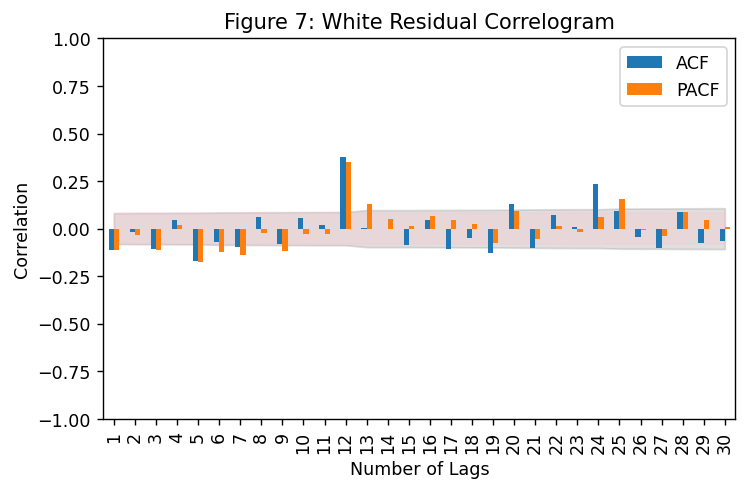

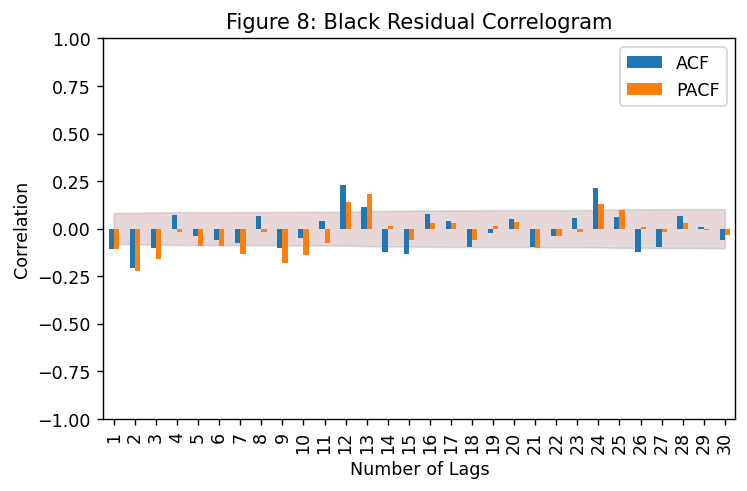

In [12]:
#Regress First-Differences on Seasonal Dummies and Look at Correlograms
for idx, eth in enumerate(['White','Black']):
    model = sm.OLS(df[eth+'_LPR_D1'][1:],df[['month_1', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12']][1:])
    result = model.fit()
    correlogram(result.resid[1:],plot_title = 'Figure ' + str(idx + 7) + ': ' + eth +' Residual Correlogram', display_table = False)

c:\users\kghet\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
c:\users\kghet\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


                                     SARIMAX Results                                      
Dep. Variable:                          White_LPR   No. Observations:                  473
Model:             SARIMAX(1, 1, 0)x(1, 0, 0, 12)   Log Likelihood                  80.532
Date:                            Sat, 01 May 2021   AIC                           -155.063
Time:                                    14:04:37   BIC                           -142.592
Sample:                                01-01-1972   HQIC                          -150.158
                                     - 05-01-2011                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2854      0.048     -5.926      0.000      -0.380      -0.191
ar.S.L12       0.9055      0.013   

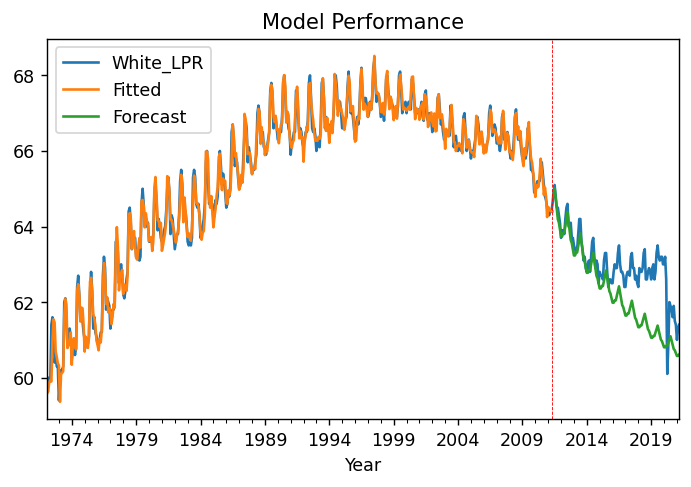

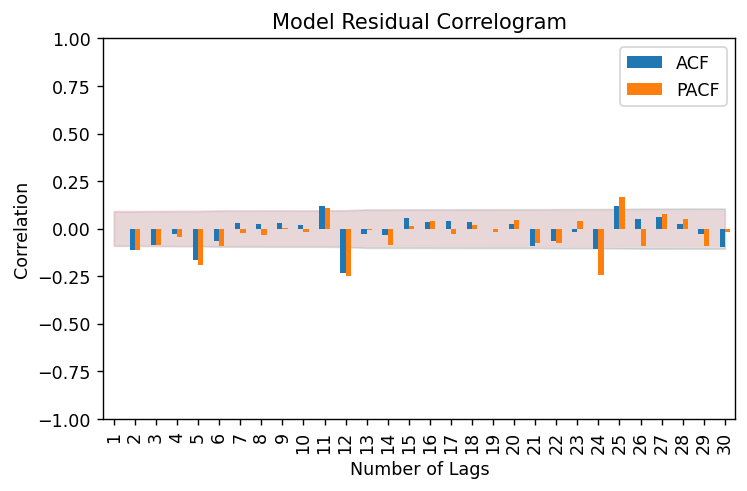

In [13]:
#White:
model = sm.tsa.SARIMAX(df_train[['White_LPR']],order = (1,1,0), seasonal_order = (1,0,0,12),trend=[0])
result = model.fit()
print(result.summary())
eval_forecast(result, df_train[['White_LPR']], df_test[['White_LPR']])

c:\users\kghet\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
c:\users\kghet\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


                                     SARIMAX Results                                      
Dep. Variable:                          Black_LPR   No. Observations:                  473
Model:             SARIMAX(1, 1, 0)x(1, 0, 0, 12)   Log Likelihood                -391.108
Date:                            Sat, 01 May 2021   AIC                            790.216
Time:                                    14:04:39   BIC                            806.844
Sample:                                01-01-1972   HQIC                           796.757
                                     - 05-01-2011                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0021      0.021     -0.098      0.922      -0.043       0.039
ar.L1         -0.1966      0.049   

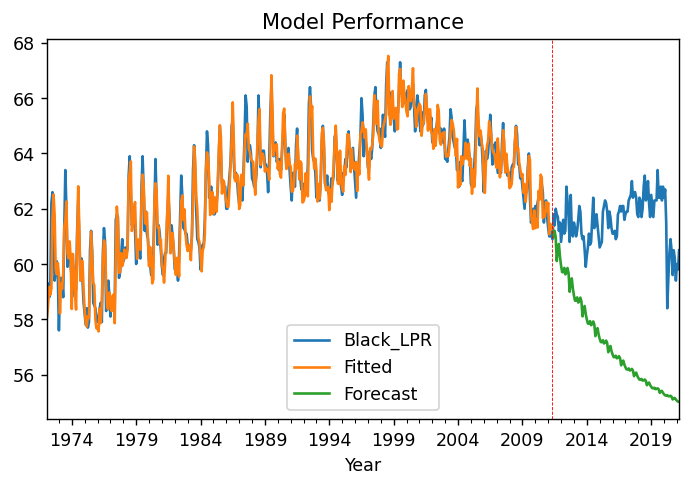

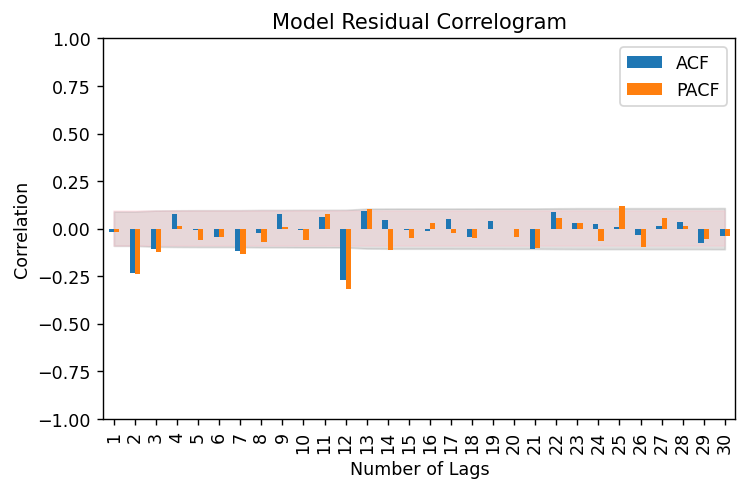

In [14]:
#Black:
model = sm.tsa.SARIMAX(df_train[['Black_LPR']],order = (1,1,0), seasonal_order = (1,0,0,12),trend=[1])
result = model.fit()
print(result.summary())
eval_forecast(result, df_train[['Black_LPR']], df_test[['Black_LPR']])

c:\users\kghet\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
c:\users\kghet\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


                                      SARIMAX Results                                      
Dep. Variable:                           Black_LPR   No. Observations:                  473
Model:             SARIMAX(1, 1, 1)x(1, 0, [], 12)   Log Likelihood                -366.588
Date:                             Sat, 01 May 2021   AIC                            743.175
Time:                                     14:04:40   BIC                            763.960
Sample:                                 01-01-1972   HQIC                           751.351
                                      - 05-01-2011                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
cons        8.587e-07   6548.617   1.31e-10      1.000   -1.28e+04    1.28e+04
ar.L1          0.6311      

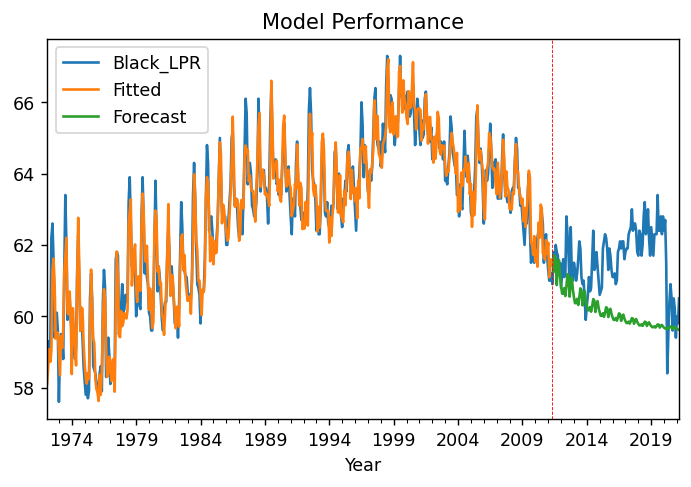

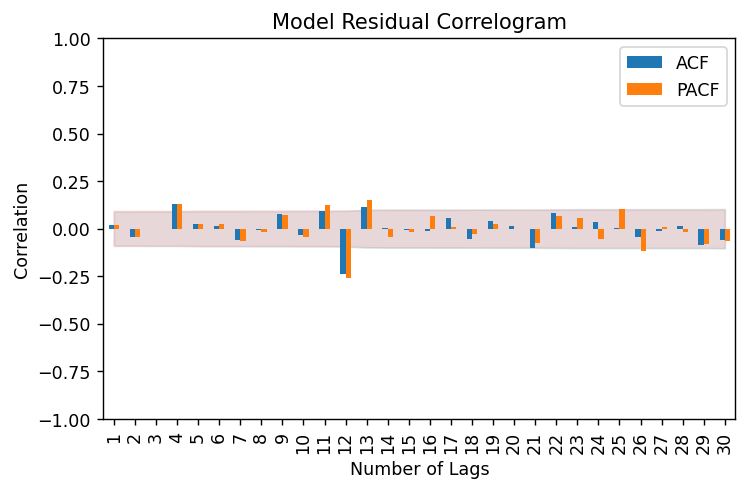

In [15]:
#Black:
model = sm.tsa.SARIMAX(df_train[['Black_LPR']],order = (1,1,1), seasonal_order = (1,0,0,12),trend=[0], exog = df_train['cons'])
result = model.fit()
print(result.summary())
eval_forecast(result, df_train[['Black_LPR']], df_test[['Black_LPR']], future_exog = df_test[['cons']])

c:\users\kghet\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
c:\users\kghet\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
c:\users\kghet\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                      SARIMAX Results                                       
Dep. Variable:                            Black_LPR   No. Observations:                  473
Model:             SARIMAX(2, 1, 2)x(1, 0, [1], 12)   Log Likelihood                -293.604
Date:                              Sat, 01 May 2021   AIC                            605.208
Time:                                      14:04:43   BIC                            642.621
Sample:                                  01-01-1972   HQIC                           619.924
                                       - 05-01-2011                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
cons        4.641e-06     24.457    1.9e-07      1.000     -47.936      47.936
t1            -0.01

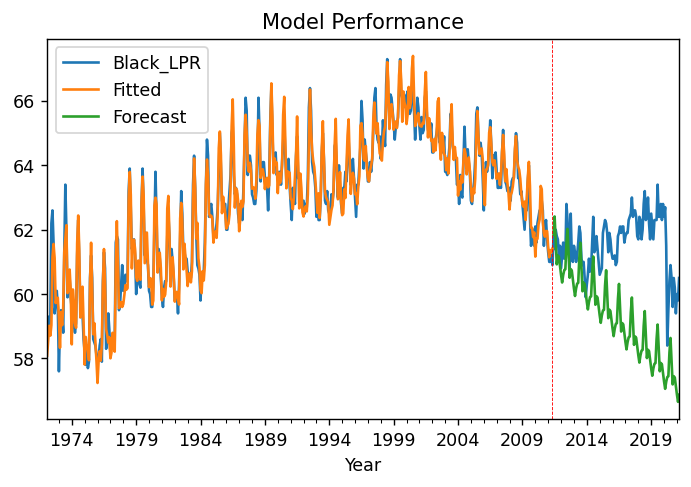

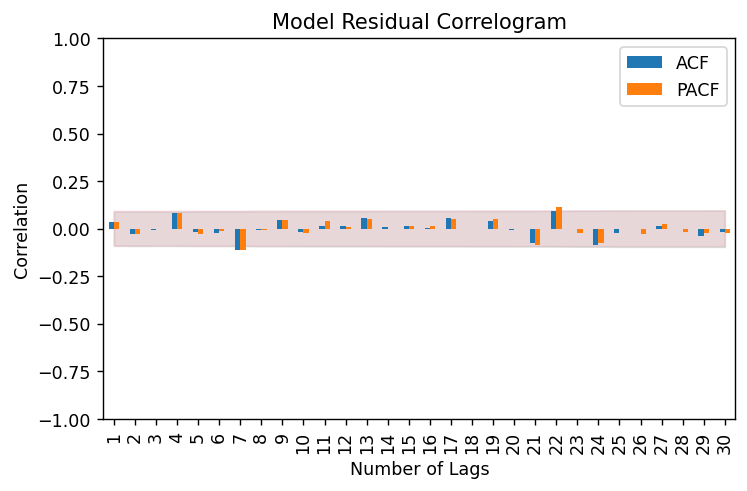

In [16]:
#Black:
model = sm.tsa.SARIMAX(df_train[['Black_LPR']],order = (2,1,2), seasonal_order = (1,0,1,12),trend=[0], exog = df_train[['cons','t1']])
result = model.fit()
print(result.summary())
eval_forecast(result, df_train[['Black_LPR']], df_test[['Black_LPR']], future_exog = df_test[['cons','t1']])

# Scrap-Cells
---
---


c:\users\kghet\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
c:\users\kghet\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


                                      SARIMAX Results                                      
Dep. Variable:                           White_LPR   No. Observations:                  473
Model:             SARIMAX(1, 1, 1)x(1, 0, [], 12)   Log Likelihood                  89.672
Date:                             Sat, 01 May 2021   AIC                           -169.344
Time:                                     14:04:45   BIC                           -148.559
Sample:                                 01-01-1972   HQIC                          -161.168
                                      - 05-01-2011                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   3.146e-06      0.001      0.002      0.998      -0.003       0.003
ar.L1          0.4931      

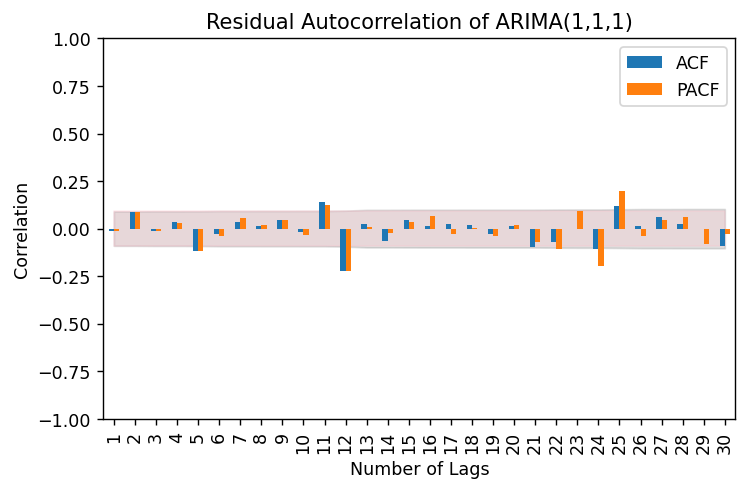

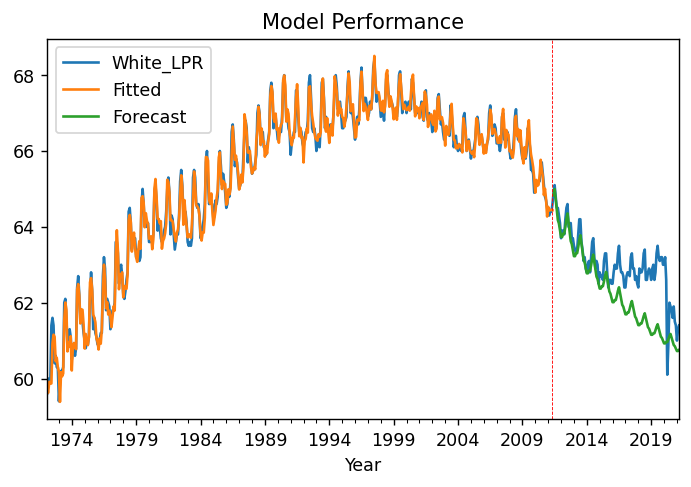

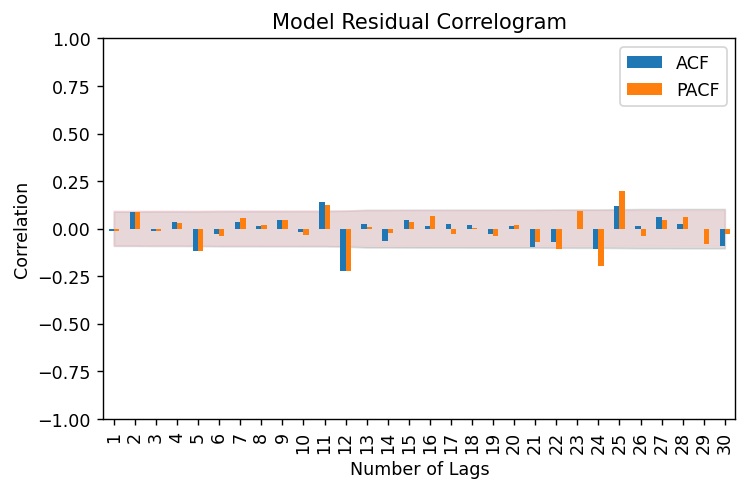

In [17]:
#test some ARIMA or SARIMA stuff:
model = sm.tsa.SARIMAX(df_train[['White_LPR']],order = (1,1,1), seasonal_order = (1,0,0,12),trend=[1])
result = model.fit()
print(result.summary())
correlogram(result.resid[1:], display_table=False, plot_title = 'Residual Autocorrelation of ARIMA(1,1,1)')
eval_forecast(result, df_train[['White_LPR']], df_test[['White_LPR']])

c:\users\kghet\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
c:\users\kghet\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
c:\users\kghet\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                      SARIMAX Results                                      
Dep. Variable:                           White_LPR   No. Observations:                  473
Model:             SARIMAX(1, 1, 1)x(1, 0, [], 12)   Log Likelihood                  94.779
Date:                             Sat, 01 May 2021   AIC                           -173.558
Time:                                     14:04:48   BIC                           -140.302
Sample:                                 01-01-1972   HQIC                          -160.477
                                      - 05-01-2011                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   6.018e-05      0.002      0.038      0.969      -0.003       0.003
gop_house     -0.1451      

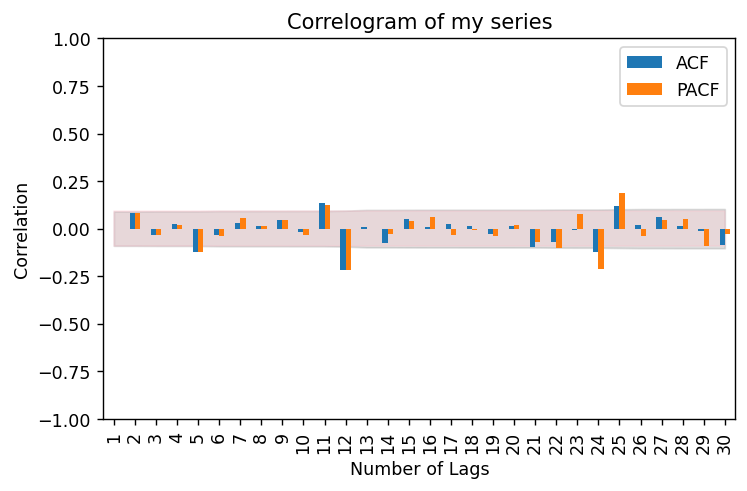

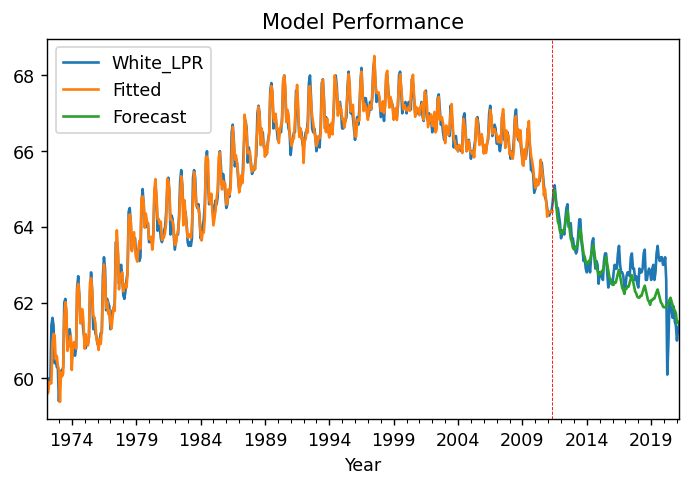

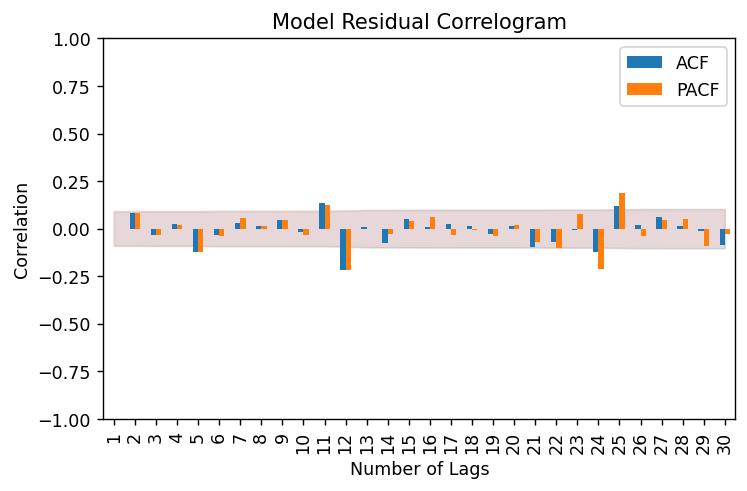

In [18]:
#test some ARIMA or SARIMA stuff:
model = sm.tsa.SARIMAX(df_train[['White_LPR']],order = (1,1,1), seasonal_order = (1,0,0,12),trend=[1], exog = df_train[['gop_house','gop_senate','gop_potus']])
result = model.fit()
print(result.summary())
correlogram(result.resid[1:], display_table=False)
eval_forecast(result, df_train[['White_LPR']], df_test[['White_LPR']], future_exog = df_test[['gop_house','gop_senate','gop_potus']])

c:\users\kghet\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
c:\users\kghet\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


                                      SARIMAX Results                                      
Dep. Variable:                           White_LPR   No. Observations:                  473
Model:             SARIMAX(1, 1, 1)x(1, 0, [], 12)   Log Likelihood                  93.508
Date:                             Sat, 01 May 2021   AIC                           -175.016
Time:                                     14:04:50   BIC                           -150.075
Sample:                                 01-01-1972   HQIC                          -165.205
                                      - 05-01-2011                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept  -2.606e-05      0.002     -0.017      0.986      -0.003       0.003
gop_potus      0.1667      

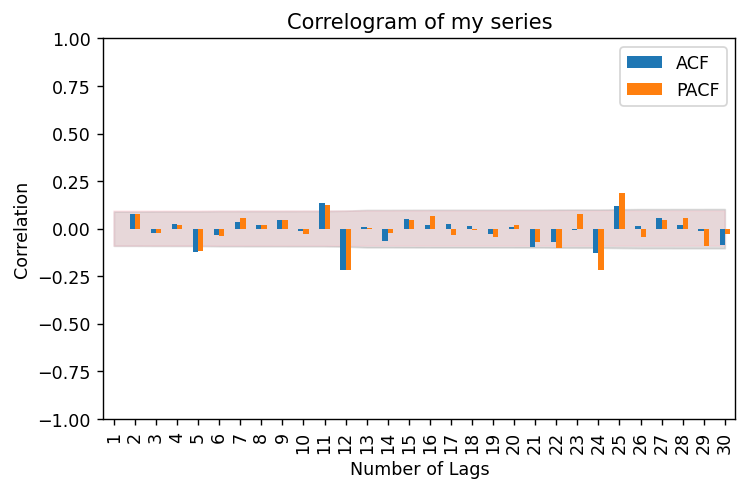

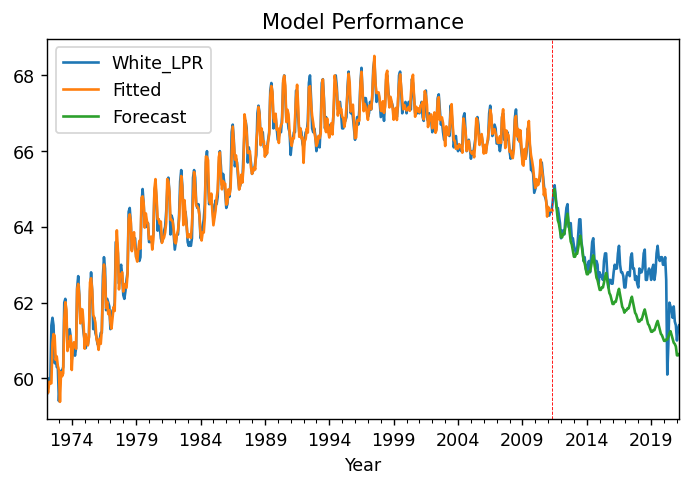

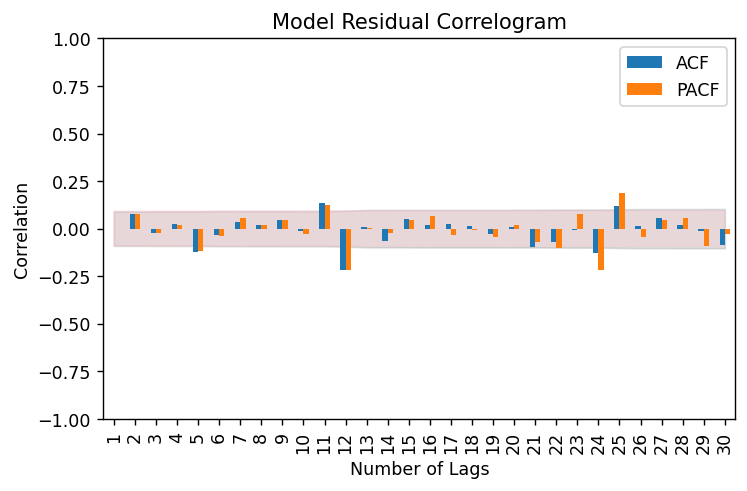

In [19]:
#test some ARIMA or SARIMA stuff:
model = sm.tsa.SARIMAX(df_train[['White_LPR']],order = (1,1,1), seasonal_order = (1,0,0,12),trend=[1], exog = df_train[['gop_potus']])
result = model.fit()
print(result.summary())
correlogram(result.resid[1:], display_table=False)
eval_forecast(result, df_train[['White_LPR']], df_test[['White_LPR']], future_exog = df_test[['gop_potus']])

c:\users\kghet\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
c:\users\kghet\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


                                      SARIMAX Results                                      
Dep. Variable:                           Black_LPR   No. Observations:                  473
Model:             SARIMAX(1, 1, 1)x(1, 0, [], 12)   Log Likelihood                -366.588
Date:                             Sat, 01 May 2021   AIC                            741.175
Time:                                     14:04:52   BIC                            757.803
Sample:                                 01-01-1972   HQIC                           747.716
                                      - 05-01-2011                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6311      0.049     12.807      0.000       0.535       0.728
ma.L1         -0.9330      

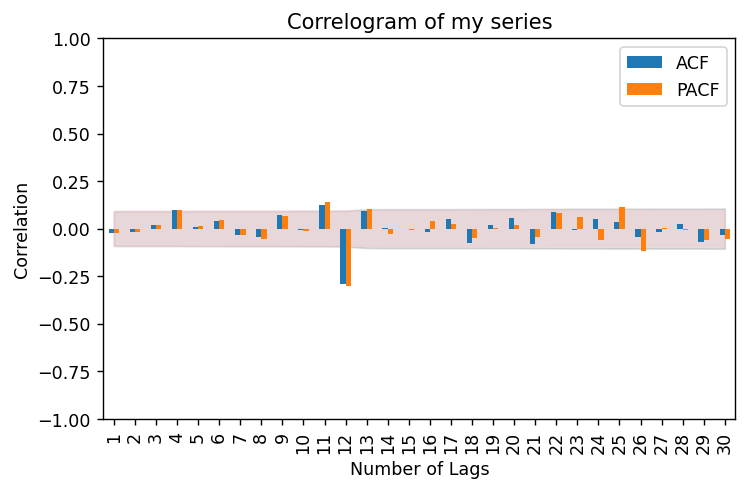

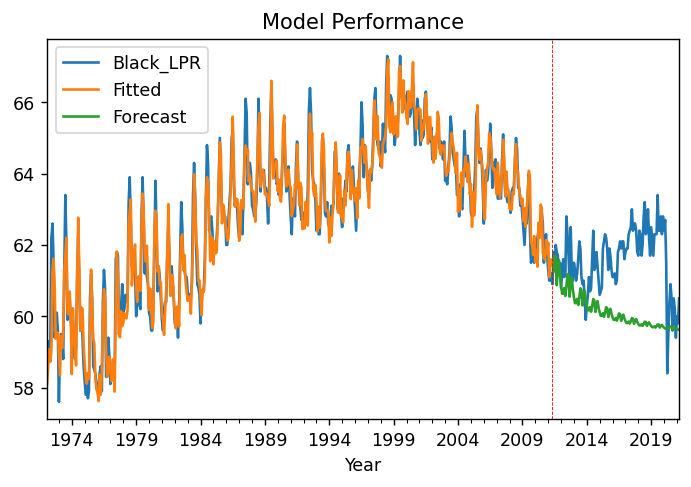

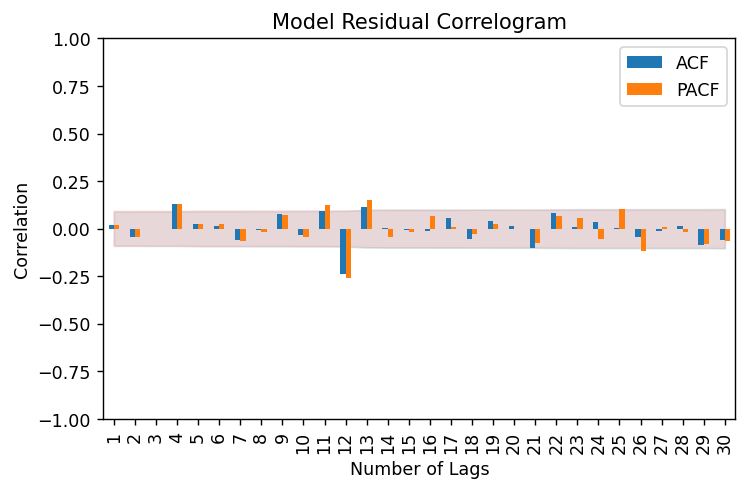

In [20]:
#test some ARIMA or SARIMA stuff:
model = sm.tsa.SARIMAX(df_train[['Black_LPR']],order = (1,1,1), seasonal_order = (1,0,0,12),trend=[0])
result = model.fit()
print(result.summary())
correlogram(result.resid[12:], display_table=False)
eval_forecast(result, df_train[['Black_LPR']], df_test[['Black_LPR']])

c:\users\kghet\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
c:\users\kghet\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


                                      SARIMAX Results                                      
Dep. Variable:                           Black_LPR   No. Observations:                  473
Model:             SARIMAX(1, 1, 1)x(1, 0, [], 12)   Log Likelihood                -364.767
Date:                             Sat, 01 May 2021   AIC                            743.533
Time:                                     14:04:55   BIC                            772.632
Sample:                                 01-01-1972   HQIC                           754.980
                                      - 05-01-2011                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
gop_house     -0.0798      0.275     -0.290      0.772      -0.619       0.459
gop_senate    -0.0137      

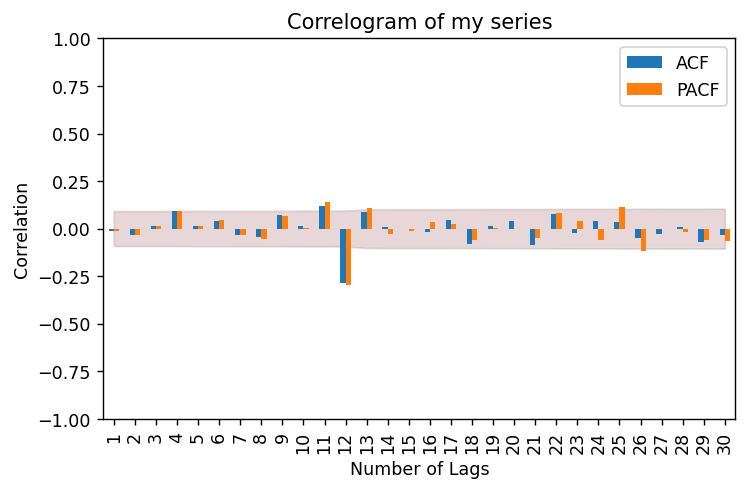

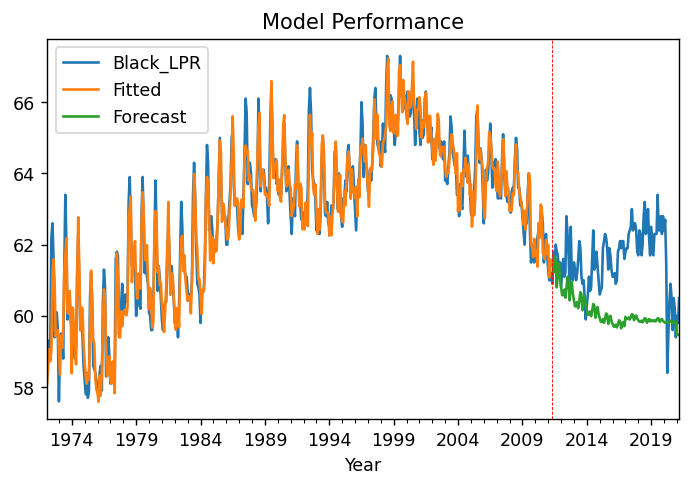

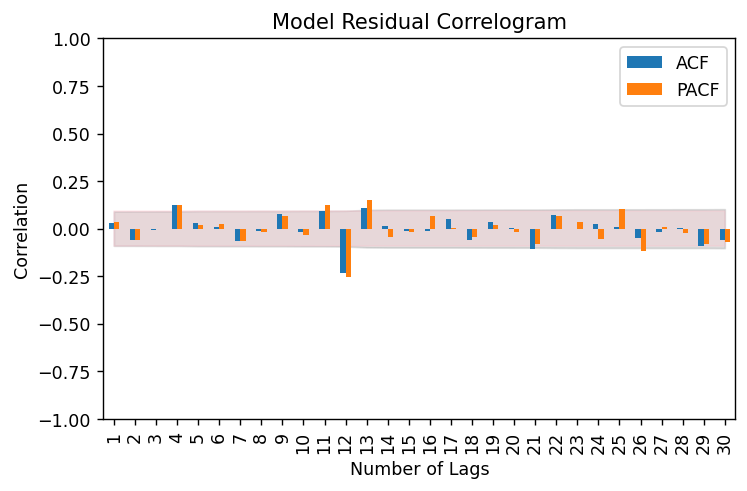

In [21]:
#test some ARIMA or SARIMA stuff:
model = sm.tsa.SARIMAX(df_train[['Black_LPR']],order = (1,1,1), seasonal_order = (1,0,0,12),trend=[0],exog = df_train[['gop_house','gop_senate','gop_potus']])
result = model.fit()
print(result.summary())
correlogram(result.resid[12:], display_table=False)
eval_forecast(result, df_train[['Black_LPR']], df_test[['Black_LPR']], future_exog = df_test[['gop_house','gop_senate','gop_potus']])

c:\users\kghet\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
c:\users\kghet\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


                                      SARIMAX Results                                      
Dep. Variable:                           Black_LPR   No. Observations:                  473
Model:             SARIMAX(1, 1, 1)x(1, 0, [], 12)   Log Likelihood                -364.850
Date:                             Sat, 01 May 2021   AIC                            739.701
Time:                                     14:04:57   BIC                            760.486
Sample:                                 01-01-1972   HQIC                           747.877
                                      - 05-01-2011                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
gop_potus      0.3220      0.176      1.825      0.068      -0.024       0.668
ar.L1          0.5953      

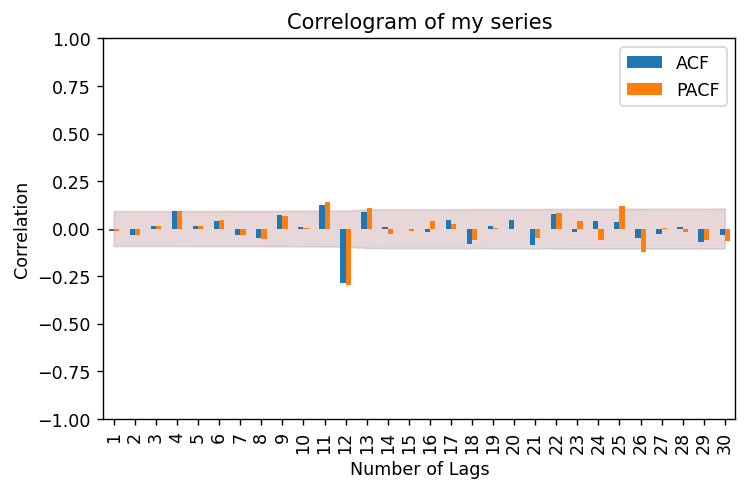

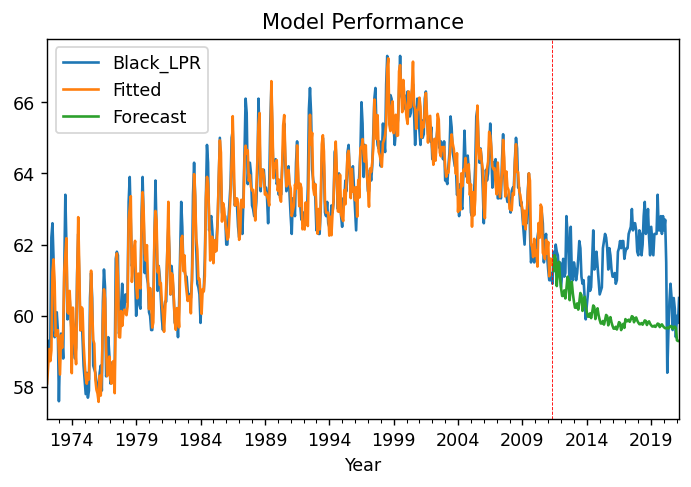

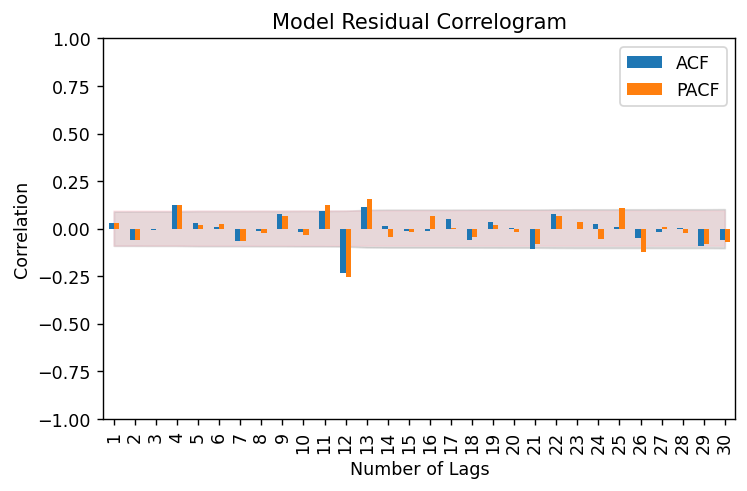

In [22]:
#test some ARIMA or SARIMA stuff:
model = sm.tsa.SARIMAX(df_train[['Black_LPR']],order = (1,1,1), seasonal_order = (1,0,0,12),trend=[0],exog = df_train[['gop_potus']])
result = model.fit()
print(result.summary())
correlogram(result.resid[12:], display_table=False)
eval_forecast(result, df_train[['Black_LPR']], df_test[['Black_LPR']], future_exog = df_test[['gop_potus']])

c:\users\kghet\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
c:\users\kghet\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
c:\users\kghet\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                      SARIMAX Results                                      
Dep. Variable:                           Black_LPR   No. Observations:                  473
Model:             SARIMAX(1, 0, 1)x(1, 0, [], 12)   Log Likelihood                -301.995
Date:                             Sat, 01 May 2021   AIC                            635.989
Time:                                     14:05:02   BIC                            702.535
Sample:                                 01-01-1972   HQIC                           662.163
                                      - 05-01-2011                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
month_1       61.5210      0.735     83.743      0.000      60.081      62.961
month_2       61.5390      

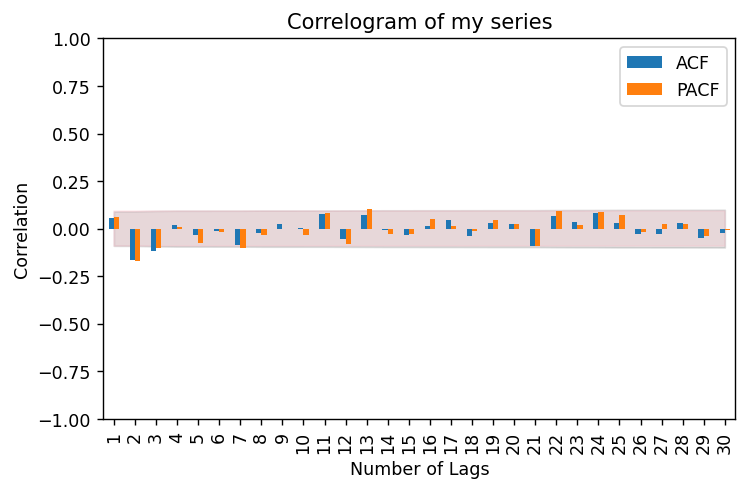

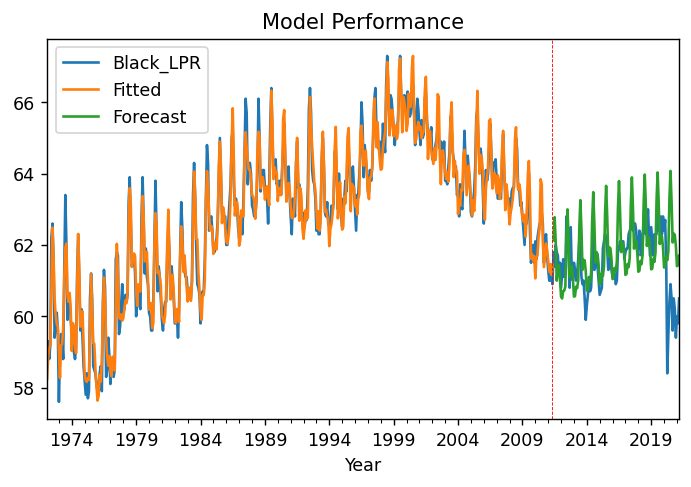

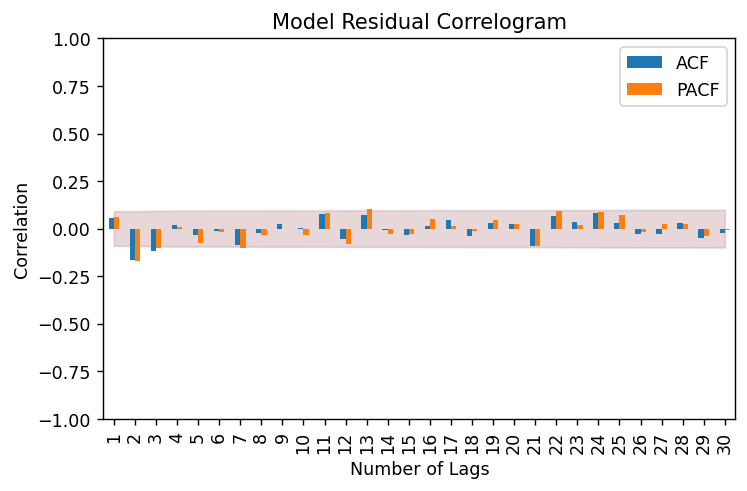

In [23]:
#test some ARIMA or SARIMA stuff:
model = sm.tsa.SARIMAX(df_train[['Black_LPR']],order = (1,0,1), seasonal_order = (1,0,0,12),trend=[0], exog = df_train[['month_1', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12']])
result = model.fit()
print(result.summary())
correlogram(result.resid[1:], display_table=False)
eval_forecast(result, df_train[['Black_LPR']], df_test[['Black_LPR']], future_exog = df_test[['month_1', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12']])

In [24]:
df.to_csv(r"C:\Users\kghet\OneDrive\Documents\2. JHU\10. Macroeconomic Forecasting\DataSets\FinalProjectSeries.csv")

PermissionError: [Errno 13] Permission denied: 'C:\\Users\\kghet\\OneDrive\\Documents\\2. JHU\\10. Macroeconomic Forecasting\\DataSets\\FinalProjectSeries.csv'

In [ ]:
df_test.head()